# Get Short Stories from Reddit
This notebook will get the top short stories from the /r/shortstories subreddit.
It filters posts that aren't stories and posts that are too long. 

In [108]:
import requests
import json
import re
from pprint import pprint
from time import sleep
import pandas as pd
import matplotlib

In [88]:
desired_number = 1000
count = 0
fetch_limit = 100
url='https://www.reddit.com/r/shortstories/top/.json?t=year'
headers = {'User-agent': 'Mozilla/5.0'}
params = {'limit': str(fetch_limit)}
posts = []
while count < desired_number:
    r = requests.get(url, headers=headers, params=params)
    if r.status_code == 200:
        data = r.json()
        posts += data['data']['children']
        count += fetch_limit
        params['after'] = data['data']['after']
        sleep(1)
    else:
        print('Error: ' + str(r.status_code))
        break

In [121]:
def parse_post(post: dict) -> dict:
    title = re.sub("\[\w+\]\s*", "", post['data']['title'])
    return {
        'genre': post['data']['link_flair_text'],
        'title': title,
        'text': post['data']['selftext'],
        'ups': post['data']['ups'],
        'upvote_ratio': post['data']['upvote_ratio']
    }

def filter_posts(posts: list, max_length: int = 7500) -> list:
    """
    Filter out posts that aren't stories or formatted
    """
    filtered_posts = []
    bad_link_flair_text = [None, 'Meta Post','Micro Monday', 'Non-Fiction', 'Off Topic', 'Roundtable Thursday', 'Serial Sunday']
    for p in posts:
        if p['data']['link_flair_text'] in bad_link_flair_text:
            continue
        if re.search("\[\w+\]\s*",p['data']['title']) is None:
            continue
        if len(p['data']['selftext']) > max_length:
            continue
        filtered_posts.append(p)
    return filtered_posts

In [122]:
# filter and parse posts
print(len(posts))
clean_posts = filter_posts(posts)
parsed_posts = [parse_post(p) for p in clean_posts]
print(len(parsed_posts))

# save the parsed posts to shortstories.json
with open('data/shortstories.json', 'w') as f:
    json.dump(parsed_posts, f)

1000
494


# EDA to further clean the data

In [112]:
# create a dataframe from the parsed posts
# one column has the text and another has the length of the text
df = pd.DataFrame(parsed_posts)
df['text_length'] = df['text'].apply(len)

# sort the dataframe by the length of the text in ascending order
df.sort_values(by='text_length', ascending=True, inplace=True)
df.head()

,genre,title,text,ups,upvote_ratio,text_length
66,Misc Fiction,The Anchor,I was born with an anchor in my chest. It was...,15,0.95,2533
585,Realistic Fiction,Evoke,Dear ———\n\n\nIt’s been a while now since we’v...,4,0.83,2578
180,Horror,Who killed my mother?,Who killed my mother? She lays a few steps be...,10,0.79,2608
512,Fantasy,A Yearly Appointment,Winter was the only season when I would see he...,6,0.88,2616
506,Fantasy,Birth of The Devil,"(Layout is definitely weird, so sorry for that...",5,0.79,2621


Fontconfig warning: ignoring UTF-8: not a valid region tag


<AxesSubplot:ylabel='Frequency'>

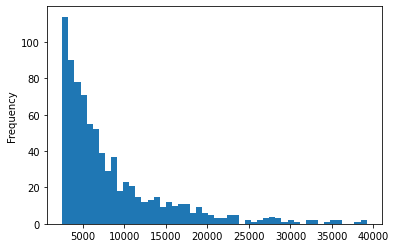

In [109]:
# plot a histogram of the text length
df['text_length'].plot(kind='hist', bins=50)

<AxesSubplot:>

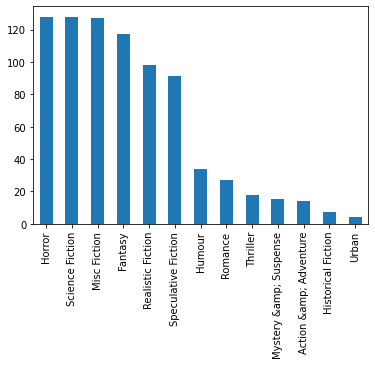

In [127]:
# plot a histogram of the genres
df['genre'].value_counts().plot(kind='bar')


<AxesSubplot:ylabel='Frequency'>

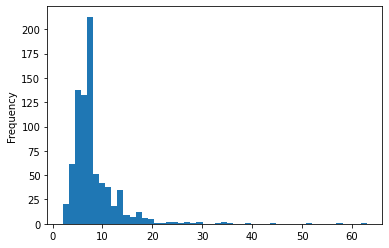

In [128]:
# plot a histogram of the ups
df['ups'].plot(kind='hist', bins=50)